In [1]:
!git clone https://github.com/kiyoshi2000/automathon-2024-B.git

Cloning into 'automathon-2024-B'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 401 (delta 143), reused 142 (delta 142), pack-reused 254
Receiving objects: 100% (401/401), 947.36 KiB | 13.73 MiB/s, done.
Resolving deltas: 100% (229/229), done.


In [2]:
!pip install -r /kaggle/working/automathon-2024-B/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 4.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 8.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 58.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.5/816.5 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.io as io
import os
import json
from tqdm import tqdm
import csv
import timm
import wandb

from PIL import Image
import torchvision.transforms as transforms

In [4]:
import matplotlib.pyplot as plt

def display_image(img):
    img = img.permute(1,2,0)
    plt.imshow(img)

def smart_resize(data, size): # kudos louis
    # Prends un tensor de shape [...,C,H,W] et le resize en [C,new_height,new_width]
    # x, y, height et width servent a faire un crop avant de resize

    full_height = data.shape[-2]
    full_width = data.shape[-1]

    if full_height > full_width:
        alt_height = size
        alt_width = int(full_width * full_height / size)
    elif full_height < full_width:
        alt_height = int(full_height * full_width / size)
        alt_width = size
    else:
        alt_height = size
        alt_width = size
    tr = transforms.Compose([
        transforms.Resize((alt_height, alt_width)),
        transforms.CenterCrop(size)
    ])
    return tr(data)

def resize_data(data, new_height, new_width, x=0, y=0, height=None, width=None):
    # Prends un tensor de shape [...,C,H,W] et le resize en [C,new_height,new_width]
    # x, y, height et width servent a faire un crop avant de resize
    
    full_height = data.shape[-2]
    full_width = data.shape[-1]
    height = full_height - y if height is None else height
    width = full_width -x if width is None else width

    ratio = new_height/new_width
    if height/width > ratio:
        expand_height = height
        expand_width = int(height / ratio)
    elif height/width < ratio:
        expand_height = int(width * ratio)
        expand_width = width
    else:
        expand_height = height
        expand_width = width
    tr = transforms.Compose([
        transforms.CenterCrop((expand_height, expand_width)),
        transforms.Resize((new_height, new_width))
    ])
    x = data[...,y:min(y+height, full_height), x:min(x+width, full_width)].clone()
    return tr(x)

In [7]:
dataset_dir = "/kaggle/input/automathon-deepfake"

root_dir = os.path.expanduser("/kaggle/input/automathon-deepfake")

nb_frames = 10

class VideoDataset(Dataset):
    """
    This Dataset takes a video and returns a tensor of shape [10, 3, 256, 256]
    That is 10 colored frames of 256x256 pixels.
    """
    def __init__(self, root_dir, dataset_choice="train", nb_frames=10):
        super().__init__()
        self.dataset_choice = dataset_choice
        if  self.dataset_choice == "train":
            self.root_dir = os.path.join(root_dir, "dataset/train_dataset")
        elif  self.dataset_choice == "test":
            self.root_dir = os.path.join(root_dir, "dataset/test_dataset")
        elif  self.dataset_choice == "experimental":
            self.root_dir = os.path.join(root_dir, "dataset/experimental_dataset")
        else:
            raise ValueError("choice must be 'train', 'test' or 'experimental'")

        with open(os.path.join(root_dir, "dataset.csv"), 'r') as file:
            reader = csv.reader(file)
            # read dataset.csv with id,label columns to create
            # a dict which associated label: id
            self.ids = {row[1][:-3] + "mp4" : row[0] for row in reader}

        if self.dataset_choice == "test":
            self.data = None
        else:
            with open(os.path.join(self.root_dir, "metadata.json"), 'r') as file:
                self.data= json.load(file)
                self.data = {k[:-3] + "mp4" : (torch.tensor(float(1)) if v == 'FAKE' else torch.tensor(float(0))) for k, v in self.data.items()}

        #self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.mp4')]
        self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.mp4')]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        print(video_path)
        
        video, audio, info = io.read_video(video_path, pts_unit='sec')
        #video = torch.load(video_path)
        '''
        video = video.permute(0,3,1,2)
        length = video.shape[0]
        video = video[[i*(length//(nb_frames)) for i in range(nb_frames)]]
        '''
        # resize the data into a reglar shape of 256x256 and normalize it
        #video = smart_resize(video, 256) / 255
        video = video / 255

        ID = self.ids[self.video_files[idx]]
        if self.dataset_choice == "test":
            return video, ID
        else:
            label = self.data[self.video_files[idx]]
            return video, label, ID

#train_dataset = VideoDataset(dataset_dir, dataset_choice="train", nb_frames=nb_frames)
#test_dataset = VideoDataset(dataset_dir, dataset_choice="test", nb_frames=nb_frames)

experimental_dataset = VideoDataset(dataset_dir, dataset_choice="experimental", nb_frames=nb_frames)


In [64]:
#experimental_dataset[0]

/kaggle/input/automathon-deepfake/dataset/experimental_dataset/vuyaffkrtu.mp4
tensor(0.)
torch.Size([152, 1080, 1920, 3])


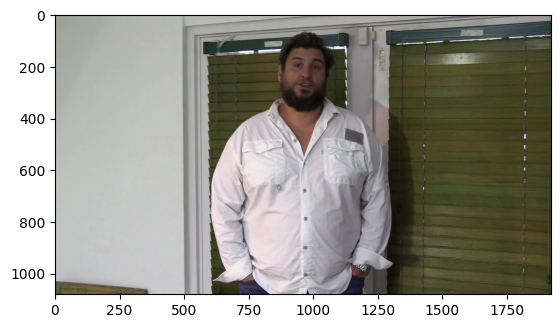

In [71]:
video, label, ID = experimental_dataset[2]
img = video[0].permute(2, 0, 1) 

display_image(img)
print(label)
print(video.shape)

In [72]:
# Convert a frame from tensor to PIL.Image
img = transforms.ToPILImage()(img)  # Assuming frames[0] is the first frame

# Call the detect_faces_in_frame function with the PIL image
#result_frame = detect_faces_in_frame(img)


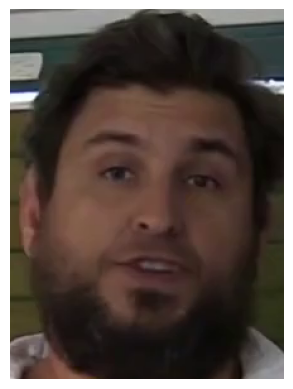

In [77]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.models.detection.keypoint_rcnn as keypoint_rcnn
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Load the pre-trained keypoint detection model
model = keypoint_rcnn.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

image = img

# Preprocess the image to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

# Perform keypoint detection on the image
with torch.no_grad():
    outputs = model(image_tensor)

# Extract keypoints from the model outputs
keypoints = outputs[0]['keypoints'][0]  # Assuming there's only one detection

# Create a bounding box around the detected face keypoints
face_keypoints_indices = [0, 1, 2, 3, 4]  # Indices corresponding to face keypoints

# Extract coordinates of keypoints used to define the bounding box
x_coords = [keypoints[i][0] for i in face_keypoints_indices]
y_coords = [keypoints[i][1] for i in face_keypoints_indices]

# Determine bounding box coordinates with extra padding
xmin = min(x_coords) - 20  
xmax = max(x_coords) + 20  
ymin = min(y_coords) - 125
ymax = max(y_coords) + 125  

# Draw the bounding box on the original image with blue color and extra padding
'''
draw = ImageDraw.Draw(image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="blue", width=3)
'''
out = np.array(img)[int(ymin):int(ymax),int(xmin):int(xmax)]
# Display the image with the bounding box
plt.close()
plt.imshow(out)
plt.axis('off')
plt.show()


In [62]:
np.array(img)[int(ymin):int(ymax),:10].shape

(210, 10, 3)

In [39]:
class DeepfakeDetector(nn.Module):
    def __init__(self, nb_frames=10):
        super().__init__()
        self.dense = nn.Linear(nb_frames * 3 * 256 * 256, 1)
        self.flat = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Flatten the input
        y = self.flat(x)
        # Apply the dense layer
        y = self.dense(y)
        # Apply the sigmoid activation function
        y = self.sigmoid(y)
        return y

# Assuming 'experimental_dataset' contains the video data
video, label, ID = experimental_dataset[0]
video = video.unsqueeze(0)  # Add a batch dimension

# Initialize the model
nb_frames = 10
model = DeepfakeDetector(nb_frames=nb_frames)

# Check the summary of the model
summary(model, input_size=(1, nb_frames * 3, 256, 256))  # Input size with batch dimension

/kaggle/input/automathon-deepfake/dataset/experimental_dataset/yjlqmmufse.mp4


Layer (type:depth-idx)                   Output Shape              Param #
DeepfakeDetector                         [1, 1]                    --
├─Flatten: 1-1                           [1, 1966080]              --
├─Linear: 1-2                            [1, 1]                    1,966,081
├─Sigmoid: 1-3                           [1, 1]                    --
Total params: 1,966,081
Trainable params: 1,966,081
Non-trainable params: 0
Total mult-adds (M): 1.97
Input size (MB): 7.86
Forward/backward pass size (MB): 0.00
Params size (MB): 7.86
Estimated Total Size (MB): 15.73